In [1]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pprint

np.random.seed(42)

import pandas as pd
from numpy.linalg import lstsq, cholesky
from scipy.linalg import sqrtm, schur, block_diag
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
from stareg.star_model import StarModel
from stareg.smooth import Smooths

In [3]:
n  = 250
x = np.linspace(1, 3, n)
x = np.random.beta(a=1, b=3, size=n) * 3
x.sort()
y = np.sin(3*x) + x
noise = np.random.normal(loc=0.0, scale=0.1, size=n)

yn = y+noise

In [4]:
Sq = Smooths(x_data=x, n_param=30, constraint="none", y=yn, lambdas={'smoothness':1, 'constraint':0}, type_="quantile")
Se = Smooths(x_data=x, n_param=30, constraint="none", y=yn, lambdas={'smoothness':1, 'constraint':0}, type_="equidistant")

M_q = StarModel(description=(("s(1)", "none", 30, (1, 0), "quantile"), ))
M_e = StarModel(description=(("s(1)", "none", 30, (1, 0), "equidistant"), ))

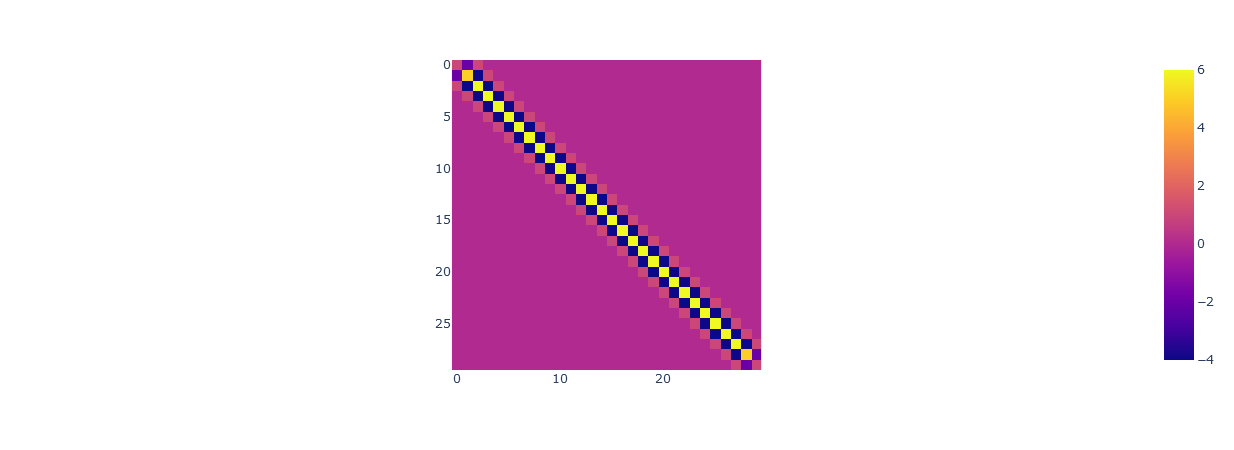

In [6]:
px.imshow(Se.smoothness)

In [12]:
# difference star according to Num Strömungsmechanik, Ferziger & Peric
msv = Sq.x_data[np.argmax(Sq.basis, axis=0)]
msv[0] = Sq.knots[2]
msv[-1] = Sq.knots[-3]
S = np.zeros((28,30))

In [19]:
Se.smoothness_matrix(30)

array([[ 1, -2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, -2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, -2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, -2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, -2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, -2,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1, -2,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, -

In [18]:
x.max()

2.404133482435724

In [10]:
for i in range(1, S.shape[0]):

    s_left = 1 / ((msv[i+1] - msv[i])*(msv[i]-msv[i-1]))
    s_center = (msv[i+1]-msv[i-1])/((msv[i+1]-msv[i])**2 * (msv[i]-msv[i-1]))
    s_right =  1 / (msv[i+1]-msv[i])**2
    S[i, i] = s_left
    S[i, i+1] = s_center
    S[i, i+2] = s_right

S /= S.max()

array([0.        , 0.12354125, 0.66179778, 0.84032388, 0.62174732,
       0.49749884, 0.61116843, 0.86325811, 0.71044469, 1.01241052,
       0.78854471, 0.47253377, 0.67699709, 0.97844075, 0.77695539,
       0.54048268, 0.51909169, 0.80771359, 0.70909786, 0.75636245,
       0.79311314, 0.58442284, 0.45041338, 0.66804652, 1.37471955,
       1.38745382, 0.83758373, 0.66405549, 0.37887811, 0.05068523])

In [35]:
M_q.GCV_smoothingParameter(X=x.reshape(-1,1), y=yn, n_grid=100, p_min=1e-8, p_max=1e10)

StarModel(s(1)={'constraint': 'none', 'knot_type': 'quantile',
                'lam': {'constraint': 657.9000000000001, 'smoothness': 0.6579},
                'n_param': 30})

In [37]:
M_e.GCV_smoothingParameter(X=x.reshape(-1,1), y=yn, n_grid=100, p_min=1e-8, p_max=1e10)

StarModel(s(1)={'constraint': 'none', 'knot_type': 'equidistant',
                'lam': {'constraint': 351119.19999999995,
                        'smoothness': 351.1192},
                'n_param': 30})

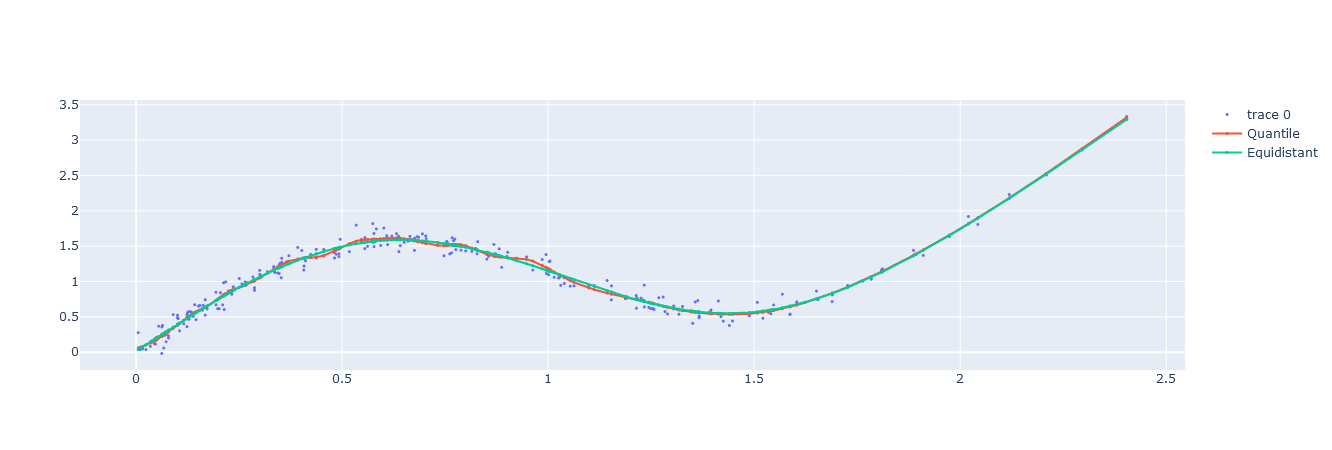

In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yn, mode="markers", marker=dict(size=3)))

fig.add_trace(go.Scatter(x=x, y=M_q.basis @ M_q.coef_, mode="markers+lines", marker=dict(size=3),  name="Quantile"))
fig.add_trace(go.Scatter(x=x, y=M_e.basis @ M_e.coef_, mode="markers+lines", marker=dict(size=3), name="Equidistant"))



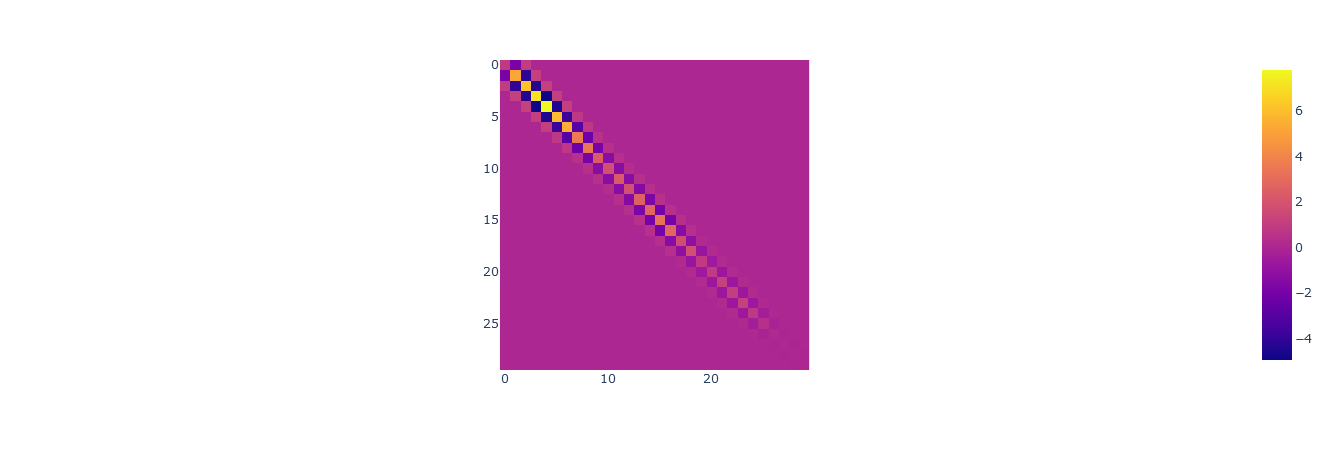

In [39]:
px.imshow(M_q.smoothness_penalty_matrix)

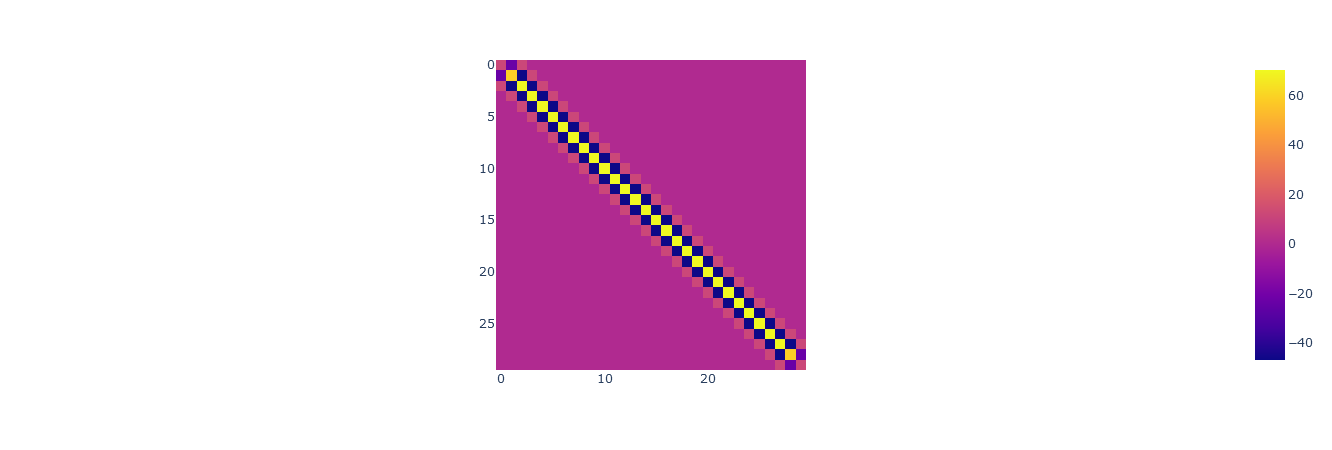

In [40]:
px.imshow(M_e.smoothness_penalty_matrix)

In [44]:
print(M_q)

{'s(1)': {'constraint': 'none',
          'knot_type': 'quantile',
          'lam': {'constraint': 657.9000000000001, 'smoothness': 0.6579},
          'n_param': 30}}


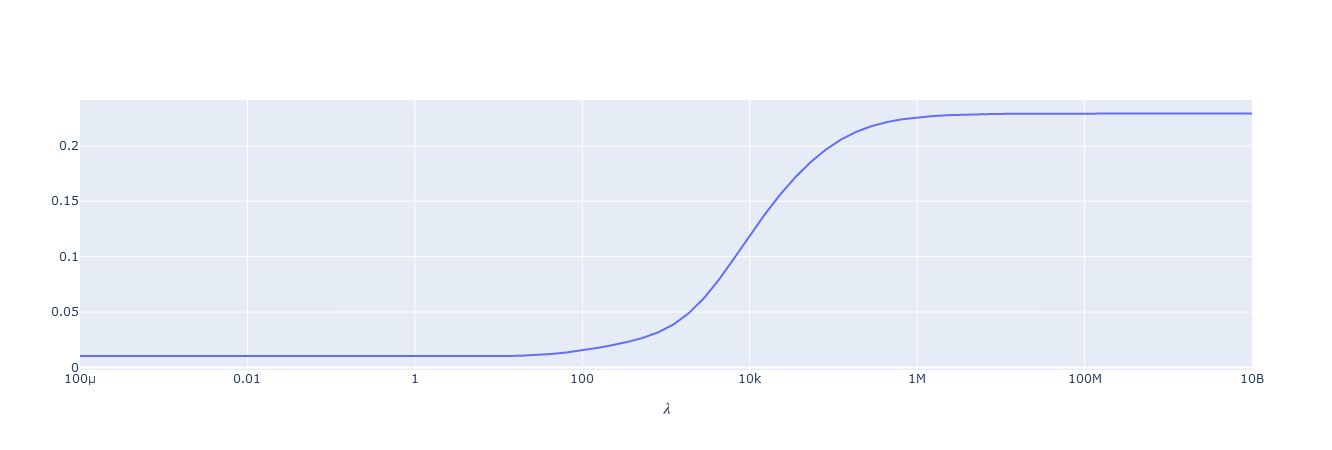

In [43]:
M_q.plot_GCV_curve()

In [19]:
M_q_1 = StarModel(description=(("s(1)", "none", 30, (1, 0), "quantile"), ))
M_q_5 = StarModel(description=(("s(1)", "none", 30, (5, 0), "quantile"), ))
M_q_05 = StarModel(description=(("s(1)", "none", 30, (0.5, 0), "quantile"), ))

In [20]:
Ms = [M_q_1, M_q_5, M_q_05]

In [21]:
for M in Ms:
    M.fit(X=x.reshape(-1,1), y=yn, plot_=False)

In [22]:
[print(M.calc_CV_score(y=yn)) for M in Ms]

0.009827967665732469
0.009917435178239878
0.009821853729117563


[None, None, None]

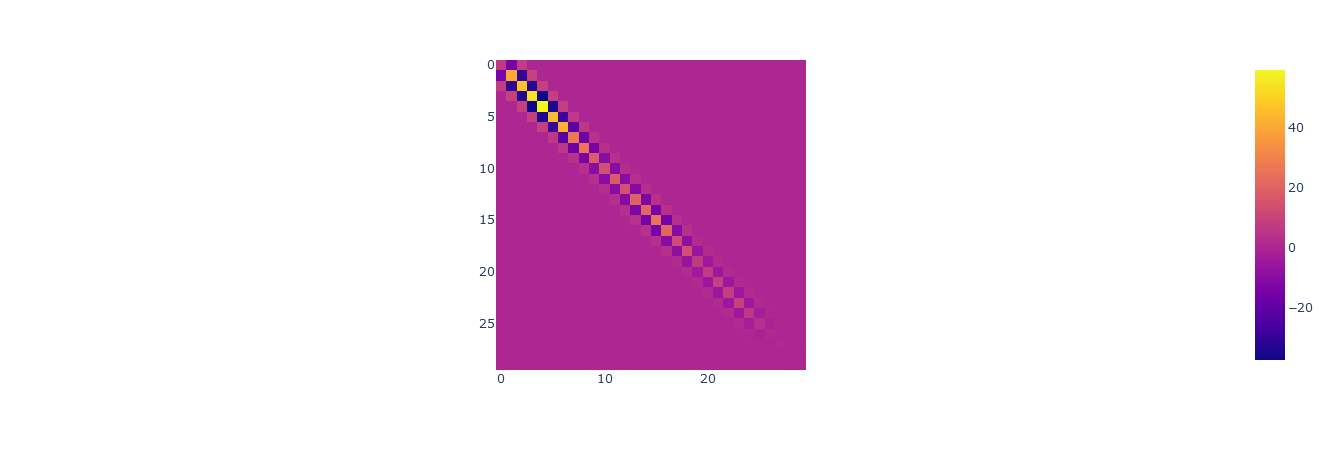

In [23]:
px.imshow(Ms[1].smoothness_penalty_matrix)

# test some derivative stuff from [Wood](https://link.springer.com/article/10.1007/s11222-016-9666-x)


In [12]:
m1 = 3
m2 = 1
p = m1 - m2

In [13]:
P, H = np.zeros((p+1,p+1)), np.zeros((p+1, p+1))

In [14]:
P

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [15]:
for i in range(1, p+1):
    for j in range(1, p+1):
        P[i,j] = (-1 + 2*(i - 1)/p)**j
        H[i,j] = (1 + (-1)**(i+j-2)) / (i+j-1)

In [16]:
W = P.T @ H @

SyntaxError: invalid syntax (<ipython-input-16-e97bfd5760de>, line 1)